In [79]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import random as ra
import math

from sklearn.cluster import AgglomerativeClustering
from collections import defaultdict
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.patches as mpatches

from skimage.morphology import skeletonize
import networkx as nx
from scipy.ndimage import distance_transform_edt

In [72]:
input_size = 784
hidden_size0 = 32
hidden_size1 = 16     
out_size = 10 #binary for whether it is digit or not
        
epochs = 10            
batch_size = 1000 #just for loading more data easily
learning_rate = 0.001

In [73]:
train_dataset = datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [74]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size0)     #784 - 32
        self.fc1 = nn.Linear(hidden_size0, hidden_size1)   #32 - 16
        self.fc2 = nn.Linear(hidden_size1, out_size)       #16 - 10
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.fc0.weight) #only works with ReLU
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        out = self.relu(self.fc0(x))
        out = self.relu(self.fc1(out))
        out = self.fc2(out) #no ReLU because final decision would be altered, couldn't be "fixed" by other weights anymore, has to stay true!
        return out

In [75]:
net = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()

file_pth = 'binary_ffn_all.pth'
net.load_state_dict(torch.load(file_pth)) #pre-trained

<All keys matched successfully>

In [76]:
with torch.no_grad():
    correct = 0
    for images, labels in test_loader:
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()
        images = images.view(-1, 28*28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / len(test_dataset)))

Accuracy of the network on the 10000 test images: 96.6 %


In [627]:
def extract_concepts(img):
    img_np = img.cpu().numpy()
    filtered = img_np > 0.5 #becuase skeleton works on binary 1, 0 data

    skeleton = skeletonize(filtered)
    skeleton_np = skeleton.astype(bool)

    size = 10
    maxoverlap = 7
    height, width = 28, 28

    neighbors_offsets = [(dy, dx) for dy in [-1,0,1] for dx in [-1,0,1] if not (dy == 0 and dx == 0)]

    def get_neighbors(p):
        y, x = p
        result = []
        for dy, dx in neighbors_offsets:
            ny, nx = y + dy, x + dx
            if 0 <= ny < height and 0 <= nx < width and skeleton_np[ny, nx]:
                result.append((ny, nx))
        return result

    groups = []
    groups_sets = []

    def dfs(path, visited):
        if len(path) == size:
            path_set = set(path)
            if not any(len(path_set & g) > maxoverlap for g in groups_sets):
                groups.append(np.array(path))
                groups_sets.append(path_set)
            return

        candidates = set()
        for p in path:
            for n in get_neighbors(p):
                if n not in visited:
                    candidates.add(n)

        for n in candidates:
            visited.add(n)
            dfs(path + [n], visited)
            visited.remove(n)

    all_pixels = list(zip(*np.nonzero(skeleton_np)))

    for start in all_pixels:
        dfs([start], set([start]))

    tensor_groups = torch.stack([
        torch.zeros((height, width), dtype=torch.uint8).index_put_(
            (torch.tensor(g[:, 0]), torch.tensor(g[:, 1])), 
            torch.ones(len(g), dtype=torch.uint8)
        ) for g in groups
    ])

    original_clusters = torch.zeros_like(tensor_groups)
    original_clusters = []

    for i in range(tensor_groups.shape[0]):
        mask = tensor_groups[i].numpy()
        inverted_mask = 1 - mask
        distance = distance_transform_edt(inverted_mask)
        within_range_mask = (distance <= 2).astype(np.float32)
        new_input = torch.from_numpy(img_np * within_range_mask).float()
        original_clusters.append(new_input)

    return tensor_groups, original_clusters

Text(0.5, 1.0, 'Label: 8')

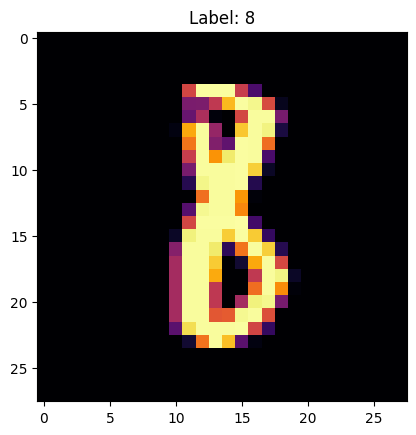

In [628]:
inputs, labels = next(iter(test_loader))

#search wanted digit:
while True:
    ind = ra.randrange(0, len(inputs))
    if labels[ind] == 8: #ra.randint(0, 9):
        img = inputs[ind].squeeze()
        break

plt.imshow(img, cmap="inferno")
plt.title(f"Label: {labels[ind].item()}")

In [629]:
tensor_groups, original_clusters = extract_concepts(img)

In [656]:
indn = 0

/tmp/ipykernel_177659/3352714123.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(img, device=img.device),


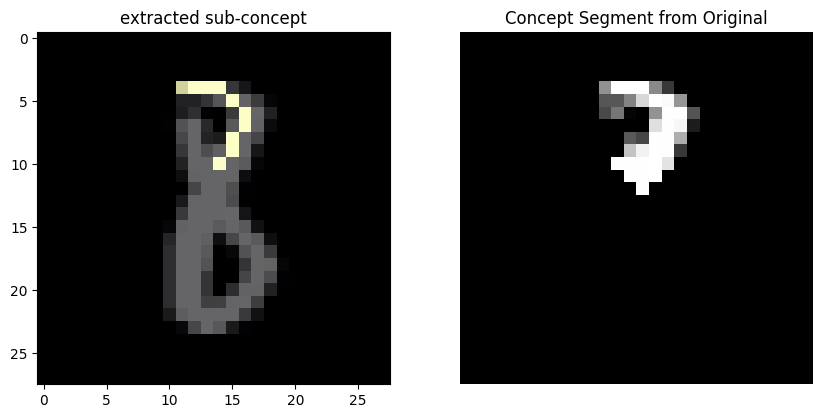

In [657]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('extracted sub-concept')
plt.imshow(img.squeeze().cpu().numpy(), cmap='gray')
plt.imshow(tensor_groups[indn].cpu().numpy(), cmap='inferno', alpha=0.6)

img2 = torch.where(
    img != 0,
    torch.tensor(img, device=img.device),
    0.0
)

plt.subplot(1, 2, 2)
plt.title('Concept Segment from Original')
plt.imshow(original_clusters[indn], cmap='gray')

plt.axis('off')
plt.show()

indn += 1

In [658]:
#also possible: only find very small concepts (size = 3, maxoverlap = 0 or 1) 
# and then recombine those to larger ones, would be faster than dfs and work on gpu